In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pdb
import urllib.request
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle

## Generate Data

In [3]:
df = pd.DataFrame({'x1': range(10000)})
df = df.assign(x2=df.x1 + 1,
               x3=df.x1 + 2,
               x4=df.x1 + 3,
               y=df.x1 + 4)

In [68]:
inp = np.array(df.drop('y', axis=1))
transformer = StandardScaler().fit(inp)
norm_in = transformer.transform(inp).transpose()
out = np.array(df.transpose())[-1, :]
x = torch.tensor(norm_in, dtype=torch.float).unsqueeze(-1)
target = torch.tensor(out, dtype=torch.float)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Download Data

In [3]:
HISTORY_SIZE = 8
HORIZON = 1
TRAIN_SIZE = 300000

In [4]:
urllib.request.urlretrieve ("https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip", 
                            "jena_climate_2009_2016.csv.zip")
df = pd.read_csv('jena_climate_2009_2016.csv.zip')
df = df.rename({'T (degC)': 'T', 'Date Time': 'dt'}, axis=1)
uni_df = df[['dt', 'T']]

In [5]:
uni_df.head()

,dt,T
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


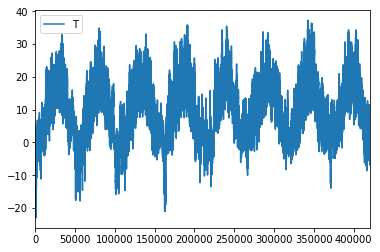

In [7]:
uni_df.plot()

In [5]:
train_df = df.loc[0:TRAIN_SIZE, ["T"]]
test_df = df.loc[TRAIN_SIZE:, ["T"]]

In [6]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, ['T'])])
train_array = preprocessor.fit_transform(train_df)
test_array = preprocessor.transform(test_df)

In [7]:
class NpDataset(Dataset):
    def __init__(self, x, window_size, target_size):
        self.x = x
        self.window_size = window_size
        self.target_size = target_size
        
    def __len__(self): 
        return self.x.shape[0] - self.window_size - self.target_size
    
    def __getitem__(self, i): 
        return self.x[i:(i + self.window_size)], self.x[(i + 1):(i + 1 + self.target_size)]

In [28]:
train_ds = NpDataset(torch.from_numpy(train_array).float(), 8, 1)
test_ds = NpDataset(torch.from_numpy(test_array).float(), 8, 1)

In [29]:
train_dl = DataLoader(train_ds, batch_size=10000)
test_dl = DataLoader(test_ds, batch_size=10000)

## Build Model

In [50]:
class SRNN(nn.Module):
  def __init__(self, seq_len=4, input_size=1, hidden_size=5, dropout_p=0.1):
    super(SRNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, dropout=dropout_p)
    self.fc1 = nn.Linear(seq_len*hidden_size, 1)
    
  def forward(self, x):
    out, hidden = self.rnn(x.permute(1, 0, 2))
    out = out.permute(1, 0, 2)
    out = nn.ReLU()(out)
    bs = out.shape[0]
    out = out.contiguous().view(bs, -1)
    out = self.fc1(out)
    return out

In [11]:
class SLSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=5, dropout_p=0):
    super(SLSTM, self).__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, dropout=dropout_p)
    self.fc1 = nn.Linear(4*hidden_size, 1)
    
  def forward(self, x):
    out, hidden = self.rnn(x)
    out = out.permute(1, 0, 2)
    bs = out.shape[0]
    out = out.contiguous().view(bs, -1)
    out = self.fc1(out)
    return out

In [12]:
def train_model(model, lr, dl, num_epochs):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  crit = nn.MSELoss()

  for epoch in range(num_epochs):
    # training
    ave_loss = 0
    for i, data in enumerate(dl):
        x, target = data
        optimizer.zero_grad()
        out = model(x)
        loss = crit(out.squeeze(), target.squeeze())
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'==>>> epoch: {epoch + 1}, batch_num: {i + 1}  train loss: {ave_loss}')

In [51]:
lr = 0.1
model = SRNN(seq_len=8, dropout_p=0.2)
train_model(model, lr, train_dl, 5)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


==>>> epoch: 1, batch_num: 1  train loss: 0.21726572513580322
==>>> epoch: 1, batch_num: 11  train loss: 0.43358706287949444
==>>> epoch: 1, batch_num: 21  train loss: 0.6462800645391304
==>>> epoch: 2, batch_num: 1  train loss: 0.014236715435981751
==>>> epoch: 2, batch_num: 11  train loss: 0.09026115492088702
==>>> epoch: 2, batch_num: 21  train loss: 0.0664489098179768
==>>> epoch: 3, batch_num: 1  train loss: 0.029284608364105225
==>>> epoch: 3, batch_num: 11  train loss: 0.06964700807876362
==>>> epoch: 3, batch_num: 21  train loss: 0.1029219081420724
==>>> epoch: 4, batch_num: 1  train loss: 0.0295994371175766
==>>> epoch: 4, batch_num: 11  train loss: 0.03380828545866125
==>>> epoch: 4, batch_num: 21  train loss: 0.03158790858911916
==>>> epoch: 5, batch_num: 1  train loss: 0.004706555604934693
==>>> epoch: 5, batch_num: 11  train loss: 0.08008744380424185
==>>> epoch: 5, batch_num: 21  train loss: 0.13387799270144907


In [55]:
lr = 0.01
train_model(model, lr, train_dl, 5)

==>>> epoch: 1, batch_num: 1  train loss: 0.0181627631187439
==>>> epoch: 1, batch_num: 11  train loss: 0.03074492285084834
==>>> epoch: 1, batch_num: 21  train loss: 0.021368918138928248
==>>> epoch: 2, batch_num: 1  train loss: 0.0006683927029371262
==>>> epoch: 2, batch_num: 11  train loss: 0.0031895982400643565
==>>> epoch: 2, batch_num: 21  train loss: 0.0024149223119691652
==>>> epoch: 3, batch_num: 1  train loss: 0.00031672948971390725
==>>> epoch: 3, batch_num: 11  train loss: 0.0008103800705698435
==>>> epoch: 3, batch_num: 21  train loss: 0.0010270392477299125
==>>> epoch: 4, batch_num: 1  train loss: 0.00027298140339553355
==>>> epoch: 4, batch_num: 11  train loss: 0.0006764228696808602
==>>> epoch: 4, batch_num: 21  train loss: 0.000890548889307958
==>>> epoch: 5, batch_num: 1  train loss: 0.00024845257867127656
==>>> epoch: 5, batch_num: 11  train loss: 0.0006287547699792795
==>>> epoch: 5, batch_num: 21  train loss: 0.0008267667522917696


In [56]:
y_preds = []
naive_y_preds = []
y_true = []
with torch.no_grad():
    for i, data in enumerate(test_dl):
        x, y = data
        y_pred = model(x)
        y_preds.append(y_pred)
        naive_y_preds.append(x[:, -1, :])
        y_true.append(y)

In [57]:
all_y_preds = torch.cat(y_preds).squeeze()
all_naive_y_preds = torch.cat(naive_y_preds).squeeze()
all_y_true = torch.cat(y_true).squeeze()

In [58]:
torch.abs(all_y_preds - all_y_true).mean(), F.mse_loss(all_y_preds, all_y_true)

(tensor(0.0190), tensor(0.0008))

In [45]:
torch.abs(all_naive_y_preds - all_y_true).mean(), F.mse_loss(all_naive_y_preds, all_y_true)

(tensor(0.0810), tensor(0.0133))

## Archive

In [171]:
def univariate_data(arr, history_size, target_size):
    data = []
    labels = []

    start_index = history_size
    end_index = arr.shape[0] - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(arr[indices, :], (history_size, 1)))
        labels.append(arr[i+target_size, :])
    data = np.moveaxis(np.array(data), (0, 1), (1, 0))
    return np.array(data), np.array(labels)

def prepare_data(array, history_size, target_size):
    x, target = univariate_data(array, history_size, target_size)
    x = torch.tensor(x, dtype=torch.float)
    target = torch.tensor(target, dtype=torch.float)
    return x, target

In [187]:
def load_or_generate_torch_data(arr, is_train=True):
    prefix = 'train' if is_train else 'test'
    try:
        with open(f'{prefix}_data_{HISTORY_SIZE}_{HORIZON}.pkl', 'rb') as f:
            data = pickle.load(f)
        x, target = data
    except:
        x, target = prepare_data(arr, HISTORY_SIZE, HORIZON)
        data = (x, target)
        with open(f'{prefix}_data_{HISTORY_SIZE}_{HORIZON}.pkl', 'wb') as f:
            pickle.dump(train_data, f)
    return x, target

In [180]:
train_data = load_or_generate_torch_data(train_array, True)
train_x, train_target = train_data

In [188]:
test_data = load_or_generate_torch_data(test_array, False)
test_x, test_target = test_data

In [61]:
def train_model(model, lr, x, target, num_epochs):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  crit = nn.MSELoss()

  for epoch in range(num_epochs):
      # training
      ave_loss = 0
      optimizer.zero_grad()
      out = model(x)
      loss = crit(out.squeeze(), target)
      ave_loss = ave_loss * 0.9 + loss.item() * 0.1
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
        print(f'==>>> epoch: {epoch},  train loss: {ave_loss}')